In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18
from transformers import Wav2Vec2Model
from torch.utils.data import Dataset, DataLoader
import cv2
from tqdm import tqdm
import av
import torchaudio
from pydub import AudioSegment
import random
import os
import pickle
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache
import torch.nn.functional as F
from torchvision.models import resnet50
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup
from IPython.display import clear_output
import torchvision.models
from torchvision.models.video import r3d_18
import io
from torchvision.transforms import transforms

## –î–∞–Ω–Ω—ã–µ


0 - –º–µ–Ω—å—à–µ —Å—Ç–∞ —Ç—ã—Å—è—á –ø—Ä–æ—Å–º–æ—Ç—Ä–æ–≤, 1 - –æ—Ç —Å—Ç–∞ –¥–æ –ø—è—Ç–∏—Å–æ—Ç —Ç—ã—Å—è—á, 2 - –æ—Ç –ø—è—Ç–∏—Å–æ—Ç –¥–æ –º–∏–ª–ª–ª–∏–æ–Ω–∞, 3 - —Å—É–ø–µ—Ä –≤–∏—Ä—É—Å–Ω—ã–π, –æ—Ç 1 –º–∏–ª–ª–ª–∏–æ–Ω–∞

In [ ]:
def mm(x):
  if x<=100000:
    x = 0
  elif (x>100000) & (x<500000):
    x = 1
  elif (x>500000) & (x<1000000):
    x = 2
  else:
    x = 3
  return x

In [ ]:
dfik = pd.read_csv('full_df.csv')

In [ ]:
dfik['youtube_views'] =  dfik['youtube_views'].apply(lambda x: mm(x)  )

In [ ]:
dfik = dfik.iloc[:,:6]

In [ ]:
dfik

Unnamed: 0.1     id                                   movie_title  \
0                0    629                            The Usual Suspects   
1                1  10160  A Nightmare on Elm Street 5: The Dream Child   
2                2  11452                 National Lampoon‚Äôs Van Wilder   
3                3  12163                                  The Wrestler   
4                4  32275                               Duel in the Sun   
...            ...    ...                                           ...   
1819          1202  16619                               Ordinary People   
1820          1203   1725                               West Side Story   
1821          1204  11977                                    Caddyshack   
1822          1205  20322                                  The Brothers   
1823          1206  16158                                      The Wood   

                                           trailer_path  youtube_views  \
0                   trailers/The_Usual_Suspects_629.mp4              0   
1     trailers/A_Nightmare_on_Elm_Street_5__The_Drea...              1   
2      trailers/National_Lampoon_s_Van_Wilder_11452.mp4              3   
3                       trailers/The_Wrestler_12163.mp4              1   
4                    trailers/Duel_in_the_Sun_32275.mp4              0   
...                                                 ...            ...   
1819                 trailers/Ordinary_People_16619.mp4              0   
1820                  trailers/West_Side_Story_1725.mp4              1   
1821                      trailers/Caddyshack_11977.mp4              0   
1822                    trailers/The_Brothers_20322.mp4              1   
1823                        trailers/The_Wood_16158.mp4              2   

      youtube_likes  
0              97.0  
1            1898.0  
2               0.0  
3            1348.0  
4             307.0  
...             ...  
1819           44.0  
1820          650.0  
1821          152.0  
1822         1253.0  
1823            0.0  

[1824 rows x 6 columns]

## –î–∞—Ç–∞—Å–µ—Ç –∏ –î–∞—Ç–∞–ª–æ–∞–¥–µ—Ä

–î–∞—Ç–∞—Å–µ—Ç –∏–∑–≤–ª–µ–∫–∞—Ç –∏–∑ –≤—Å–µ–≥–æ –≤–∏–¥–µ–æ—Ä—è–¥–∞ —Ç–æ–ª—å–∫–æ –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –∫—É—Å–∫–∏,–Ω–∞—á–∏–Ω–∞—è —Å —Ä–∞–Ω–¥–æ–º–Ω–æ–≥–æ start_frame. –í—Å–µ–≥–æ –∏–∑–≤–ª–µ–∫–∞–µ—Ç—Å—è 60 –∫–∞–¥—Ä–æ–≤ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —Ç—Ä–µ–π–ª–µ—Ä–∞. –ê—É–¥–∏–æ—Ä—è–¥ –±–µ—Ä–µ—Ç—Å—è –∏–∑ —Å–æ–æ—Ç–≤–µ—Ç—Å–≤—É—é–µ—â–µ–≥–æ –∫—É—Å–∫–∞ –≤–∏–¥–µ–æ —Å —á–∞—Å—Ç–æ—Ç–æ–π 16000 –ì—Ü. –¢–∞–∫–∂–µ –∫–∞–¥—Ä—ã –Ω–æ—Ä–º–∞–ª–∏–∑—É—é—Ç—Å—è –≤ —Å–æ–æ—Ç–≤–µ—Å—Ç–≤–∏–∏ —Å Imagenet.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class FastTrailerDataset(Dataset):
    def __init__(self, df, target_frames=60, clip_length=2.0, audio_rate=16000, transform=None):

        self.df = df
        self.target_frames = target_frames
        self.clip_length = clip_length
        self.audio_rate = audio_rate
        self.transform = transform
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

    def _load_audio_segment(self, video_path):
        """–ë—ã—Å—Ç—Ä–∞—è –∑–∞–≥—Ä—É–∑–∫–∞ –∞—É–¥–∏–æ –æ–¥–∏–Ω —Ä–∞–∑ –¥–ª—è –≤—Å–µ–≥–æ –≤–∏–¥–µ–æ"""
        audio = AudioSegment.from_file(video_path)
        return audio.set_frame_rate(self.audio_rate).set_channels(1)

    def _extract_frames(self, cap, start_frame, fps):
        """–≠—Ñ—Ñ–µ–∫—Ç–∏–≤–Ω–æ–µ –∏–∑–≤–ª–µ—á–µ–Ω–∏–µ –∫–∞–¥—Ä–æ–≤"""
        frames = []
        for i in range(self.target_frames):
            frame_pos = start_frame + int(i * (fps * self.clip_length / self.target_frames))
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_pos)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (224, 224))
                frame = torch.from_numpy(frame).float() / 255.0
                frame = frame.permute(2, 0, 1)
                frame = self.normalize(frame)
                frames.append(frame)
            else:
                frames.append(torch.zeros((224, 224, 3), dtype=torch.float32))
        return torch.stack(frames, dim = 1)  # (T, C, H, W)

    def _extract_audio(self, audio_seg, start_sec):
        """–û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ –∏–∑–≤–ª–µ—á–µ–Ω–∏–µ –∞—É–¥–∏–æ"""
        start_ms = start_sec * 1000
        end_ms = start_ms + self.clip_length * 1000
        segment = audio_seg[start_ms:end_ms]

        # –ë—ã—Å—Ç—Ä–æ–µ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ –≤ numpy array
        samples = np.array(segment.get_array_of_samples())
        samples = samples.astype(np.float32) / (2**15)  # –ù–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è –¥–ª—è int16

        # –û–±—Ä–µ–∑–∫–∞/–¥–æ–ø–æ–ª–Ω–µ–Ω–∏–µ –¥–æ –Ω—É–∂–Ω–æ–π –¥–ª–∏–Ω—ã
        target_len = int(self.clip_length * self.audio_rate)
        if len(samples) < target_len:
            samples = np.pad(samples, (0, target_len - len(samples)))
        else:
            samples = samples[:target_len]

        return torch.from_numpy(samples).unsqueeze(0)  # (1, L)

    def __getitem__(self, idx):
        video_path = self.df.iloc[idx]['trailer_path']

        # 1. –ó–∞–≥—Ä—É–∂–∞–µ–º –∞—É–¥–∏–æ –æ–¥–∏–Ω —Ä–∞–∑ –¥–ª—è –≤—Å–µ–≥–æ –≤–∏–¥–µ–æ
        audio_seg = self._load_audio_segment(video_path)

        # 2. –û—Ç–∫—Ä—ã–≤–∞–µ–º –≤–∏–¥–µ–æ
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # 3. –í—ã–±–∏—Ä–∞–µ–º —Å–ª—É—á–∞–π–Ω—ã–π —Å—Ç–∞—Ä—Ç
        max_start_frame = max(0, total_frames - int(fps * self.clip_length))
        start_frame = random.randint(0, max_start_frame) if max_start_frame > 0 else 0
        start_sec = start_frame / fps

        # 4. –ü–∞—Ä–∞–ª–ª–µ–ª—å–Ω–æ –∏–∑–≤–ª–µ–∫–∞–µ–º –∫–∞–¥—Ä—ã –∏ –∞—É–¥–∏–æ
        frames = self._extract_frames(cap, start_frame, fps)
        audio = self._extract_audio(audio_seg, start_sec)
        audio = audio.squeeze(0)
        cap.release()

        # 5. –ü—Ä–∏–º–µ–Ω—è–µ–º —Ç—Ä–∞–Ω—Å—Ñ–æ—Ä–º–∞—Ü–∏–∏ (–µ—Å–ª–∏ –µ—Å—Ç—å)
        if self.transform:
            frames = torch.stack([self.transform(f) for f in frames])
        return {
            'rgb': torch.FloatTensor(frames),
            'audio': audio,
            'views': torch.FloatTensor([self.df.iloc[idx]['youtube_views']]),
            'path': video_path
        }


    def __len__(self):
        return len(self.df)

Using device: cuda


–ü—Ä–æ–ø–∏—à–µ–º collate fn –¥–ª—è –¥–∞—Ç–∞–ª–æ–∞–¥–µ—Ä–∞

In [ ]:
def custom_collate_fn(batch):
    # –û—Ç—Ñ–∏–ª—å—Ç—Ä–æ–≤—ã–≤–∞–µ–º None (–±–∏—Ç—ã–µ –ø—Ä–∏–º–µ—Ä—ã)
    batch = [item for item in batch if item is not None]

    # –ï—Å–ª–∏ –≤–µ—Å—å –±–∞—Ç—á —Å–æ—Å—Ç–æ–∏—Ç –∏–∑ None
    if len(batch) == 0:
        return None

    # –°–æ–±–∏—Ä–∞–µ–º –±–∞—Ç—á –¥–ª—è –∫–∞–∂–¥–æ–π –º–æ–¥–∞–ª—å–Ω–æ—Å—Ç–∏
    collated_batch = {
        'rgb': torch.stack([item['rgb'] for item in batch], dim = 0),

        'audio': torch.stack([item['audio'] for item in batch]),
        'views': torch.stack([item['views'] for item in batch]),
        'paths': [item['path'] for item in batch]  # –°–ø–∏—Å–æ–∫ –ø—É—Ç–µ–π (–Ω–µ —Ç–µ–Ω–∑–æ—Ä)
    }

    return collated_batch

In [ ]:
dataset = FastTrailerDataset(
    dfik,
    clip_length=5.0 # –≤–∑—è–ª–∏ 5 —Å–µ–∫—É–Ω–¥ –≤–∏–¥–µ–æ—Ä—è–¥–∞, —á—Ç–æ–±—ã –æ—Ö–≤–∞—Ç–∏—Ç—å –∫–∞–∫ –º–æ–∂–Ω–æ –±–æ–ª—å—à–µ —Ñ—Ä–µ–π–º–æ–≤
)

In [ ]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8,0.2])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4,
    shuffle=True,
    num_workers=0,  # –ú–æ–∂–Ω–æ —É–≤–µ–ª–∏—á–∏—Ç—å –¥–ª—è —É—Å–∫–æ—Ä–µ–Ω–∏—è –∑–∞–≥—Ä—É–∑–∫–∏
    collate_fn=custom_collate_fn,
    pin_memory = True,
    drop_last=True )
val_loader = DataLoader(val_dataset, batch_size=4,

    shuffle=False,
    num_workers=0,
    pin_memory = True,# –ú–æ–∂–Ω–æ —É–≤–µ–ª–∏—á–∏—Ç—å –¥–ª—è —É—Å–∫–æ—Ä–µ–Ω–∏—è –∑–∞–≥—Ä—É–∑–∫–∏
    collate_fn=custom_collate_fn,
    drop_last=True )

–ü–æ—Å–º–æ—Ç—Ä–∏–º –Ω–∞ –∫–∞–¥—Ä —Å –∞–≤–∞—Ç–∞—Ä–∞

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


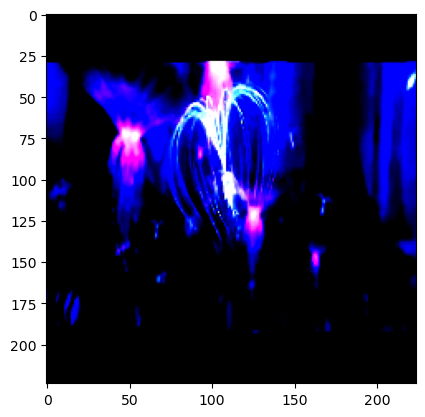

In [ ]:
plt.imshow(dataset[617].get('rgb').permute(1,2,3,0)[58])

# –ú–æ–¥–µ–ª—å


In [ ]:
backbone = r3d_18(weights="KINETICS400_V1")

In [ ]:
stage = 2

class RandomFrameClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        # 1. –í–∏–∑—É–∞–ª—å–Ω–∞—è –≤–µ—Ç–∫–∞ (—Ç–µ–ø–µ—Ä—å —Å–æ—Ö—Ä–∞–Ω—è–µ—Ç –≤—Ä–µ–º–µ–Ω–Ω—É—é –æ—Å—å)
        self.visual_backbone = nn.Sequential(
           *list(backbone.children())[:-2],
        nn.AdaptiveAvgPool3d((None, 1, 1)),
        nn.Flatten(start_dim=2)
    )
        self.frame_projection = nn.Linear(512, 512)

        # –ó–∞–º–æ—Ä–∞–∂–∏–≤–∞–µ–º –≤—Å–µ —Å–ª–æ–∏, –∫—Ä–æ–º–µ –ø–æ—Å–ª–µ–¥–Ω–µ–≥–æ
        for param in self.visual_backbone.parameters():
            param.requires_grad = False

        # 2. MultiheadAttention –¥–ª—è 60 –∫–∞–¥—Ä–æ–≤
        self.frame_attention = nn.MultiheadAttention(
            embed_dim=512,
            num_heads=8,
            dropout=0.1,
            batch_first=True  # –ò—Å–ø–æ–ª—å–∑—É–µ–º [B, T, D] —Ñ–æ—Ä–º–∞—Ç
        )
        self.layer_norm = nn.LayerNorm(512)

        # 3. –ê—É–¥–∏–æ –≤–µ—Ç–∫–∞ (–±–µ–∑ –∏–∑–º–µ–Ω–µ–Ω–∏–π)
        self.audio_backbone = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        for param in self.audio_backbone.parameters():
            param.requires_grad = False

        self.audio_projection = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU()
        )

        # 4. –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä
        self.classifier = nn.Sequential(
            nn.Linear(512 + 512, 512),  # –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤–∏–¥–µ–æ –∏ –∞—É–¥–∏–æ
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, video_frames, audio):
        B, C, T, H, W = video_frames.shape

      # 1. –ò–∑–≤–ª–µ–∫–∞–µ–º —Ñ–∏—á–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –∫–∞–¥—Ä–∞
        video_features = self.visual_backbone(video_frames)  # [B, 512, T]
        video_features = video_features.permute(0, 2, 1)  # [B, T, 512]
        video_features = self.frame_projection(video_features)  # [B, 60, 512]

      # 2. Attention –º–µ–∂–¥—É –∫–∞–¥—Ä–∞–º–∏
        attn_output, _ = self.frame_attention(
            video_features,  # [B, 60, 512]
            video_features,
            video_features
        )
        visual_features = self.layer_norm(attn_output.mean(dim=1))  # [B, 512]

        # 3. –ê—É–¥–∏–æ —Ñ–∏—á–∏
        audio_features = self.audio_backbone(audio).last_hidden_state
        audio_features = audio_features.mean(dim=1)
        audio_features = self.audio_projection(audio_features)  # [B, 512]

      # 4. –ö–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è
        combined = torch.cat([visual_features, audio_features], dim=1)
        return self.classifier(combined)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RandomFrameClassifier(num_classes=4).to(device)

# 2. –ì–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã
config = {
    'batch_size': 4,
    'num_epochs': 15,
    'learning_rate': 3e-4,
    'warmup_epochs': 2,
    'num_workers': 4,
    'gradient_clip': 1.0
}

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 3. –û–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä –∏ –ø–ª–∞–Ω–∏—Ä–æ–≤—â–∏–∫

optimizer = AdamW([

    {'params': model.visual_backbone[0].parameters(), 'lr': 1e-6},  # Frozen CNN —á–∞—Å—Ç–∏
    {'params': model.visual_backbone[-1].parameters(), 'lr': 1e-5},  # –ü–æ—Å–ª–µ–¥–Ω–∏–π –ª–∏–Ω–µ–π–Ω—ã–π —Å–ª–æ–π


    {'params': model.frame_attention.parameters(), 'lr': 3e-5},
    {'params': model.frame_projection.parameters(), 'lr': 3e-5},


    {'params': model.audio_backbone.parameters(), 'lr': 1e-6},  # Frozen wav2vec
    {'params': model.audio_projection.parameters(), 'lr': 1e-5},  # –ü—Ä–æ–µ–∫—Ü–∏—è –∞—É–¥–∏–æ


    {'params': model.classifier.parameters(), 'lr': 5e-4}
], weight_decay=0.01)

total_steps = len(train_loader) * config['num_epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(train_loader) * config['warmup_epochs'],
    num_training_steps=total_steps
)
criterion = CrossEntropyLoss()

In [ ]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # –ì—Ä–∞—Ñ–∏–∫ –ª–æ—Å—Å–∞
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # –ì—Ä–∞—Ñ–∏–∫ —Ç–æ—á–Ω–æ—Å—Ç–∏
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        rgb = batch['rgb'].to(device)
        audio = batch['audio'].to(device)
        labels = batch['views'].squeeze(1).long().to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(rgb, audio)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': correct / total
        })

    return total_loss / len(dataloader), correct / total

In [ ]:
def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            rgb = batch['rgb'].to(device)
            audio = batch['audio'].to(device)
            labels = batch['views'].squeeze(1).long().to(device)

            outputs = model(rgb, audio)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(dataloader), correct / total

## –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —á–µ–∫–ø–æ–π–Ω—Ç–æ–≤

In [ ]:
# –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–æ–¥–µ–ª—å –ø–æ—Å–ª–µ –∫–∞–∂–¥–æ–π —ç–ø–æ—Ö–∏ –∏ –æ—Ü–µ–Ω–∏–≤–∞–µ–º –º–µ—Ç—Ä–∏–∫–∏
def save_checkpoint_and_evaluate(model, val_loader, device, class_names, epoch):
    # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Å–æ—Å—Ç–æ—è–Ω–∏—è –º–æ–¥–µ–ª–∏
    checkpoint_path = f'checkpoint_epoch_{epoch}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'class_names': class_names
    }, checkpoint_path)
    print(f"‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤ {checkpoint_path}")

    # –û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏
    evaluate_classification(model, val_loader, device, class_names)


In [ ]:
def load_checkpoint(model, optimizer, scheduler, checkpoint_path, device='cuda'):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if 'scheduler_state_dict' in checkpoint and scheduler:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint.get('epoch', 0) + 1
    class_names = checkpoint.get('class_names', {})
    print(f"‚úÖ –ß–µ–∫–ø–æ–∏–Ω—Ç –∑–∞–≥—Ä—É–∂–µ–Ω: {checkpoint_path} (–Ω–∞—á–∞—Ç—å —Å —ç–ø–æ—Ö–∏ {start_epoch})")
    return model, optimizer, scheduler, start_epoch, class_names

In [ ]:
# === –ó–∞–≥—Ä—É–∑–∫–∞ –º–æ–¥–µ–ª–∏ –∏ –≤–µ—Å–æ–≤ —Å —á–µ–∫–ø–æ–π–Ω—Ç–∞ 6-–π —ç–ø–æ—Ö–∏ (–±–µ–∑ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞) ===
checkpoint = torch.load("checkpoint_epoch_6.pth", map_location=device)

# –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ —Å —Ç–æ–π –∂–µ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–æ–π
model = RandomFrameClassifier(num_classes=4).to(device)
model.load_state_dict(checkpoint['model_state_dict'])

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –Ω–æ–≤–æ–≥–æ –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä–∞ –∏ lr scheduler
lr_map = {1: 1e-4, 2: 1e-5, 3: 5e-6}
optimizer = torch.optim.Adam(model.parameters(), lr=lr_map[stage], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# –ü—Ä–æ–¥–æ–ª–∂–µ–Ω–∏–µ –æ–±—É—á–µ–Ω–∏—è —Å 7-–π —ç–ø–æ—Ö–∏
start_epoch = checkpoint['epoch'] + 1
print(f"Checkpoint loaded (weights only). Resuming training from epoch {start_epoch}")

C:\Users\litvi\AppData\Local\Temp\ipykernel_21284\3127757134.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("checkpoint_epoch_6.pth", map_locati

Checkpoint loaded (weights only). Resuming training from epoch 7


## –¶–∏–∫–ª –æ–±—É—á–µ–Ω–∏—è

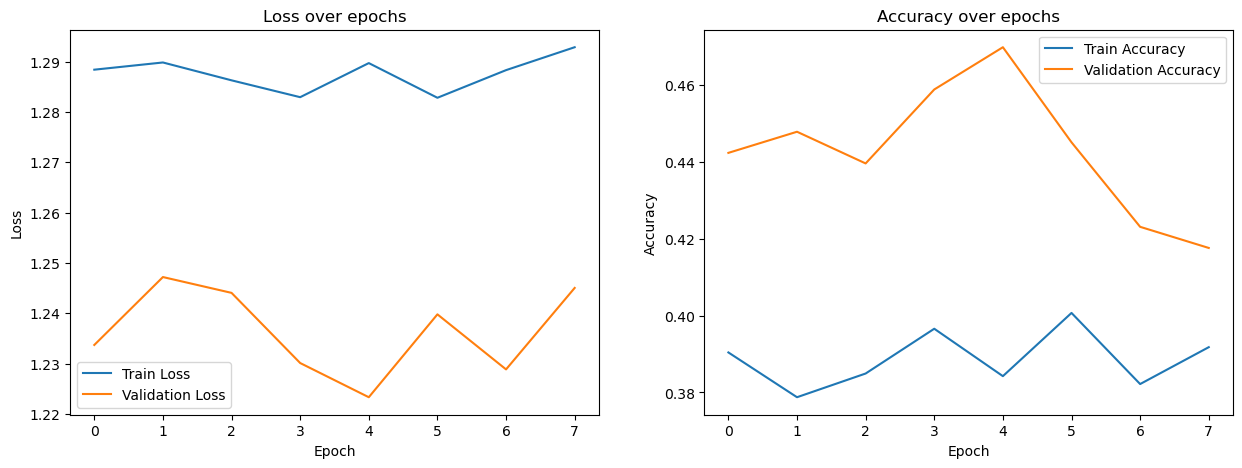


–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ñ–∏–Ω–∞–ª—å–Ω–æ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è...
–§–∏–Ω–∞–ª—å–Ω–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤ 'final_model.pth'


In [ ]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

best_val_acc = 0

class_names = {
    0: "–º–µ–Ω—å—à–µ 100 —Ç—ã—Å—è—á",
    1: "–æ—Ç 100 –¥–æ 500 —Ç—ã—Å—è—á",
    2: "–æ—Ç 500 –¥–æ 1–ú",
    3: ">1–ú"
}

# –ü—É—Ç—å –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è —á–µ–∫–ø–æ–∏–Ω—Ç–æ–≤

try:
    for epoch in range(start_epoch, config['num_epochs']):
        print(f"\nEpoch {epoch + 1}/{config['num_epochs']}")

        # –û–±—É—á–µ–Ω–∏–µ
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # –í–∞–ª–∏–¥–∞—Ü–∏—è
        val_loss, val_acc = validate(model, val_loader, device)
        scheduler.step(val_loss)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'train_loss_history': train_loss_history,
                'val_loss_history': val_loss_history,
                'train_acc_history': train_acc_history,
                'val_acc_history': val_acc_history,
                'best_val_acc': best_val_acc,
                'class_names': class_names,
                'training_date': datetime.now().strftime("%Y-%m-%d")
            }, 'best_model.pth')
            print(f"–ù–æ–≤–∞—è –ª—É—á—à–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ (Val Acc: {best_val_acc:.4f})")

        # –í—ã–≤–æ–¥ –º–µ—Ç—Ä–∏–∫
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

        # –û—Ç—Ä–∏—Å–æ–≤–∫–∞ –≥—Ä–∞—Ñ–∏–∫–æ–≤
        save_checkpoint_and_evaluate(model, val_loader, device, class_names, epoch)
        plot_metrics(train_loss_history, val_loss_history, train_acc_history, val_acc_history)

except (KeyboardInterrupt, Exception) as e:
    print(f"\n–ü—Ä–µ—Ä—ã–≤–∞–Ω–∏–µ! –≠–∫—Å—Ç—Ä–µ–Ω–Ω–æ–µ –∑–∞–≤–µ—Ä—à–µ–Ω–∏–µ... –û—à–∏–±–∫–∞: {e}")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'best_val_acc': best_val_acc,
        'class_names': class_names,
        'training_date': datetime.now().strftime("%Y-%m-%d")
    }, 'emergency_model.pth')
    raise

finally:
    print("\n–°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ñ–∏–Ω–∞–ª—å–Ω–æ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è...")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'best_val_acc': best_val_acc,
        'class_names': class_names,
        'training_date': datetime.now().strftime("%Y-%m-%d")
    }, 'final_model.pth')
    print("–§–∏–Ω–∞–ª—å–Ω–∞—è –º–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤ 'final_model.pth'")

In [ ]:
checkpoint = torch.load("best_model.pth", map_location="cpu")
val_acc_history = checkpoint.get("val_acc_history", [])

for i, acc in enumerate(val_acc_history):
    print(f"–≠–ø–æ—Ö–∞ {i+1}: val_acc = {acc:.4f}")

–≠–ø–æ—Ö–∞ 1: val_acc = 0.4423
–≠–ø–æ—Ö–∞ 2: val_acc = 0.4478
–≠–ø–æ—Ö–∞ 3: val_acc = 0.4396
–≠–ø–æ—Ö–∞ 4: val_acc = 0.4588
–≠–ø–æ—Ö–∞ 5: val_acc = 0.4698


C:\Users\litvi\AppData\Local\Temp\ipykernel_21284\3824524208.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_location="cpu"

In [ ]:
best_epoch = checkpoint.get("epoch", None)
best_val_acc = checkpoint.get("best_val_acc", None)

print(f"‚úÖ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å –±—ã–ª–∞ –Ω–∞ —ç–ø–æ—Ö–µ: {best_epoch + 1}")
print(f"üéØ Validation Accuracy –Ω–∞ –Ω–µ–π: {best_val_acc:.4f}")

C:\Users\litvi\AppData\Local\Temp\ipykernel_21284\3166534233.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth", map_location="cpu"

‚úÖ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å –±—ã–ª–∞ –Ω–∞ —ç–ø–æ—Ö–µ: 12
üéØ Validation Accuracy –Ω–∞ –Ω–µ–π: 0.4698
